Model Evaluation, ROC Analysis and Threshold Tuning

Deeper evaluation of the trained models by:
- Plotting ROC curves
- Comparing models using ROC-AUC
- Analysing the effect of different decision thresholds
- Selecting a more appropriate operating point for an early-warning system.

In [31]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [32]:
# Loading the Preprocessed Data

X_train = np.load("../data/preprocessed/X_train.npy")
X_test = np.load("../data/preprocessed/X_test.npy")
y_train = np.load("../data/preprocessed/y_train.npy")
y_test = np.load("../data/preprocessed/y_test.npy")

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (316, 56)
X_test: (79, 56)
y_train: (316,)
y_test: (79,)


Retraining the Models

We retrain the models here to ensure that this notebook is fully self-contained and reproducible.

In [33]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier( n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train);

print("Models trained")

Models trained


Getting Prediction Probabilities

We obtain the predicted probabilities for the positive class (at-risk = 1) for both models.
These probabilities will be used for ROC analysis and threshold tuning.

In [34]:
#These are risk scores
# Higher = more likely to be at risk
# We will now evaluate them for all possible thresholds

y_proba_lr = log_reg.predict_proba(X_test)[:,1]
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Probability shapes:")
print("y_proba_lr:", y_proba_lr.shape)
print("y_proba_rf:", y_proba_rf.shape)

Probability shapes:
y_proba_lr: (79,)
y_proba_rf: (79,)


ROC Curve Analysis
The ROC curve shows the trade-off between:
- True Positive Rate (Recall)
- False Positive Rate

for all possible decision thresholds.

In [35]:
# print("y_test type:", y_test))
print("y_test shape:", y_test.shape)
print("y_test dtype:", y_test.dtype)
print("First 10 values of y_test:", y_test[:10])

print("y_proba_lr shape:", y_proba_lr.shape)
print("y_proba_rf shape:", y_proba_rf.shape)


y_test shape: (79,)
y_test dtype: int64
First 10 values of y_test: [1 0 0 1 1 0 0 0 1 0]
y_proba_lr shape: (79,)
y_proba_rf shape: (79,)


In [36]:
# Compute ROC Curves
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)

# Compute AUC
auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("AUC Logistic Regression:", auc_lr)
print("AUC Random Forest:", auc_rf)

AUC Logistic Regression: 0.7148040638606676
AUC Random Forest: 0.6952104499274311


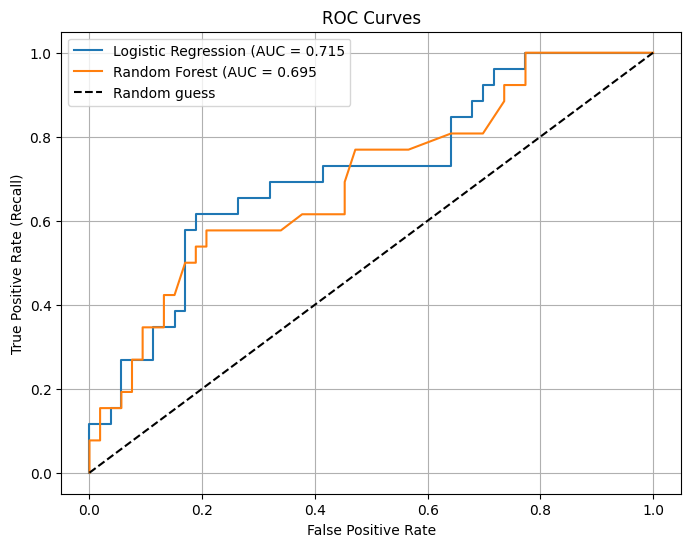

In [37]:
# Plotting ROC Curves
plt.figure(figsize=(8,6))

plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f}")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

Interpretation

- The ROC curves show the performance of both models across all possible thresholds.
- A higher curve and larger AUC indicates better ranking performance.
- However, the operating threshold still needs to be chosen based on application requirements.

In [38]:
#  Threshold Tuning (Random Forest)

# For an early-warning system, missing an at-risk student is more costly than a false alarm. Therefore, we test lower thresholds to increase recall.

threshold_to_test = [0.5,0.4,0.3,0.25,0.2]

for t in threshold_to_test:
    print(f"\n--- Threshold = {t} ---")
    y_pred_tuned = (y_proba_rf >= t).astype(int)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_tuned))
    print("Classification Report:")
    print(classification_report(y_test, y_pred_tuned))


--- Threshold = 0.5 ---
Confusion Matrix:
[[49  4]
 [20  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        53
           1       0.60      0.23      0.33        26

    accuracy                           0.70        79
   macro avg       0.66      0.58      0.57        79
weighted avg       0.67      0.70      0.65        79


--- Threshold = 0.4 ---
Confusion Matrix:
[[43 10]
 [13 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        53
           1       0.57      0.50      0.53        26

    accuracy                           0.71        79
   macro avg       0.67      0.66      0.66        79
weighted avg       0.70      0.71      0.70        79


--- Threshold = 0.3 ---
Confusion Matrix:
[[27 26]
 [ 6 20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.51   

**Conclusion:**

- ROC-AUC shows the Random Forest has better ranking performance.
- However, at the default threshold of 0.5, recall for at-risk students is too low.
- By lowering the threshold, recall can be significantly improved at the cost of more false positives.
- In a real early-warning system, such a trade-off is acceptable and often desirable.

Threshold tuning revealed a clear trade-off between recall and precision.
At the default threshold (0.5), the Random Forest model identified only 23% of at-risk students. Lowering the threshold to 0.4
doubled recall to 50% while maintaining acceptable overall accuracy (71%).

Further reductions increased recall but introduced excessive false positives. Therefore, a threshold of 0.4 was selected as a balanced operating point for an early-warning system.